# НС для линейной регрессии
Как предсказать функцию синуса

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

Тренировочный датасет

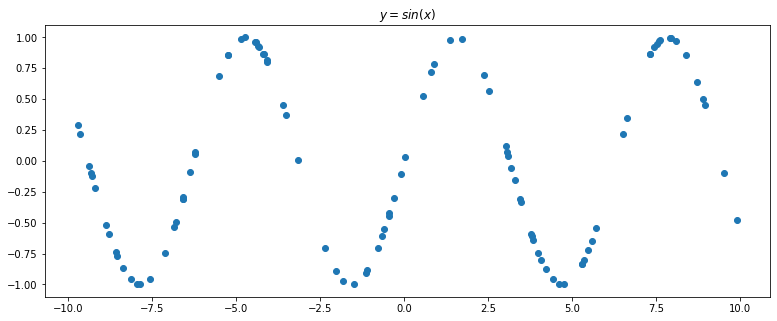

In [ ]:
x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

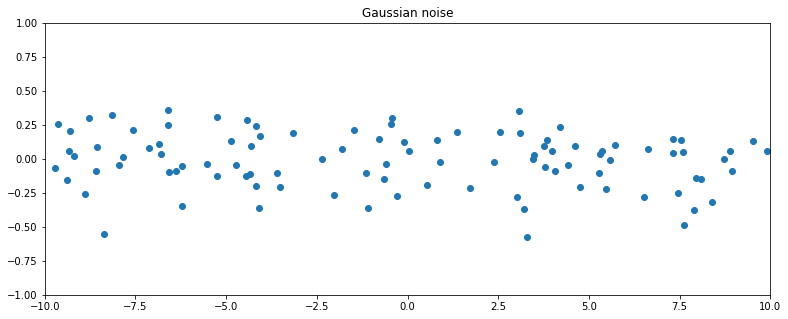

In [ ]:
# добавляем шум
noise = torch.randn(y_train.shape) / 5.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

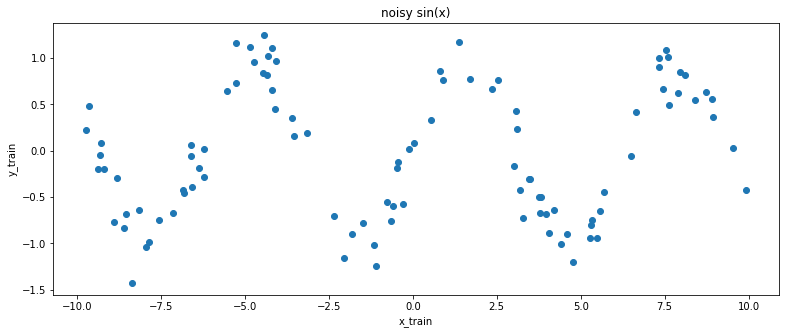

In [ ]:
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

In [ ]:
# unsqueeze_ метод необходим, чтобы привести все к одной размерности
# Нижнее подчеркивание в методе означает, что он трансформирует тот объект, к которому применяется
x_train.unsqueeze_(1)
y_train.unsqueeze_(1);

In [ ]:
# Проверяем работу метода unsqueeze_
tmp = torch.Tensor([1,2,3])
print(tmp)
print(tmp.unsqueeze(1))

tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])


Валидационный датасет

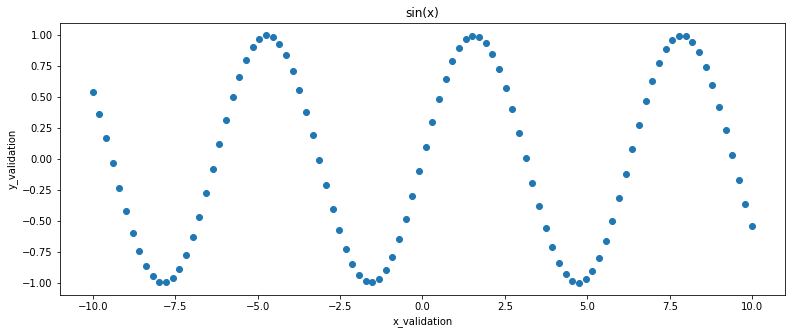

In [ ]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [ ]:
x_validation.unsqueeze_(1) # 1, так как у нас только 1 параметр???
y_validation.unsqueeze_(1);

Создаем модель

In [ ]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons) # fc - fully-connected слой - в питорче называется linear. 1 - количество входных нейронов, n_hidden_neurons - количество выходных нейронов
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # этот нейрон и выдет ответ

    def forward(self, x): # функция определяет то, как наши слои последовательно применяются
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50) # в скобках подается количество скрытых нейронов

Prediction. Пробую просто так сразу предсказать

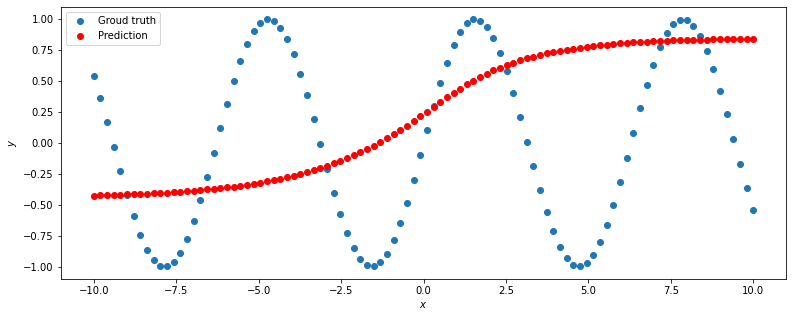

In [ ]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)

Начинаем норм обучать

Оптимизатор

In [ ]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01) # parameters - все те параметры, которые Adam может модифицировать (не точки!!!)

Loss function

In [ ]:
def loss(pred, target):
    squares = (pred - target) ** 2 # MSE
    return squares.mean()

Обучение

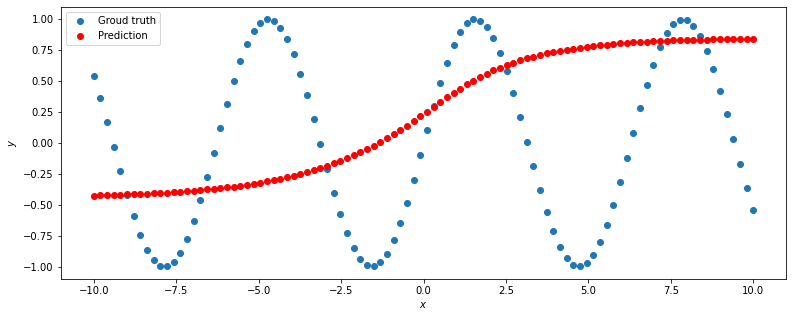

In [ ]:
for epoch_index in range(2000): # эпоха - сколько раз просмотрели наш датасет, сколько раз обучились
    optimizer.zero_grad() # зануляем градиенты у оптимайзера

    y_pred = sine_net.forward(x_train) # считаем предсказания сети
    loss_val = loss(y_pred, y_train) # считаем функцию потерь - скаляр

    loss_val.backward() # делаем бэквард по скаляру

    optimizer.step() # шаг оптимизатора

predict(sine_net, x_validation, y_validation)

Возьмем более сложную функцию

In [ ]:
def target_function(x):
    return 2**x * torch.sin(2**-x)

class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RegressionNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons) # fc - fully-connected слой - в питорче называется linear. 1 - количество входных нейронов, n_hidden_neurons - количество выходных нейронов
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # этот нейрон и выдет ответ

    def forward(self, x): # функция определяет то, как наши слои последовательно применяются
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

net = RegressionNet(5)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:


optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

def loss(pred, target):
    squares = abs(pred - target)
    return squares.mean()

for epoch_index in range(200):
    optimizer.zero_grad()

    y_pred = net.forward(x_train)
    loss_value = loss(y_pred, y_train)
    loss_value.backward()
    optimizer.step()

# Проверка осуществляется вызовом кода:
def metric(pred, target): 
  return (pred - target).abs().mean()
#
print(metric(net.forward(x_validation), y_validation).item())
# (раскомментируйте, если решаете задание локально)

0.027721751481294632


Зафиксируем случайность, так как из-за того, что при каждом запуске заново инициализируются веса и тд, мы получаем разные ответы

In [ ]:
import torch
import random
import numpy as np

random.seed(0) # номер последовательность рандомных чисел, который выдаст нам случайный генератор, если его попросить выдать нам последовательность. в данном случае это нулевая последовательность
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Используем готовый датасет

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Создаем НС

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3) # 3, так как 3 вида вина
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x): # реализует граф НС
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        # здесь не используем софтмакс, так как он не нужен для вычисления энтропии (софтмакс содержит экспоненту, в кросс-энтропии есть логарифм - они самоуничтожаются)
        return x

    def inference(self, x): # эта функциях и считает вероятности
        x = self.forward(x)
        x = self.sm(x) # а вот здесь уже используем софтмакс, так как он нужен для вычисления вероятности
        return x
    
wine_net = WineNet(5)

In [ ]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [ ]:
np.random.permutation(5) # необходимо для шафла данных, например тут выводят лист размером 5 и значениями от 0 до 5 исключительно

array([0, 3, 4, 1, 2])

In [ ]:
batch_size = 10 # кусочек всех данных, чтобы не нагружать память

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # в каждую эпоху шафлим датасет 
    for start_index in range(0, len(X_train), batch_size): # и отрезаем от него кусочек с помощью batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

Визуализируем результат

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


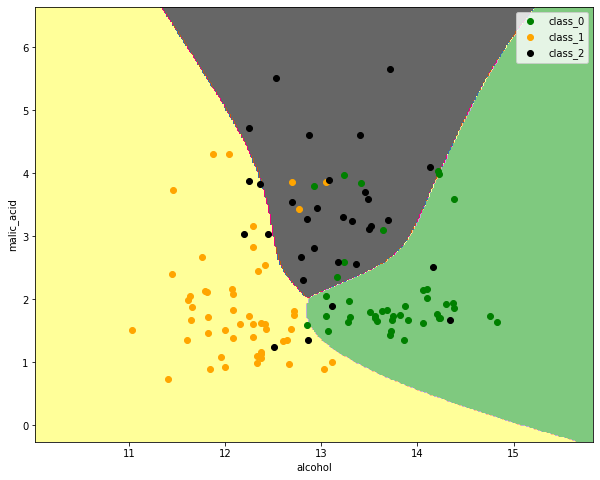

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()